In [1]:
# Based off of the tensorflow transfer learning docs and examples

import numpy as np
import tensorflow as tf
import os
import keras
import matplotlib.pyplot as plt
import cv2

import DataReader

In [2]:
TRAIN_PATH = r"C:\Users\Ethan\Desktop\filter_cat_pictures\data\train"
VALIDATION_PATH = r"C:\Users\Ethan\Desktop\filter_cat_pictures\data\validation"
BATCH_SIZE = 32
IMG_SIZE = (299, 299)

In [3]:
dr = DataReader.DataReader(TRAIN_PATH, VALIDATION_PATH, BATCH_SIZE, IMG_SIZE)

Found 2662 files belonging to 2 classes.
Found 877 files belonging to 2 classes.


In [4]:
train_dataset = dr.train_dataset
validation_dataset = dr.validation_dataset

In [6]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = dr.validation_dataset.take(val_batches // 5)
validation_dataset = dr.validation_dataset.skip(val_batches // 5)

In [7]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [8]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [10]:
preprocess_input = tf.keras.applications.inception_resnet_v2.preprocess_input

IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.InceptionResNetV2(input_shape=IMG_SHAPE,
                                                     include_top=False,
                                                     weights="imagenet")

In [11]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 8, 8, 1536)


In [12]:
base_model.trainable = False

In [13]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1536)


In [14]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [15]:
inputs = tf.keras.Input(shape=(299, 299, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [16]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [18]:
base_model.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
________________________________________________________________________________

__________________________________________________________________________________________________
batch_normalization_178 (BatchN (None, 8, 8, 256)    768         conv2d_178[0][0]                 
__________________________________________________________________________________________________
activation_175 (Activation)     (None, 8, 8, 192)    0           batch_normalization_175[0][0]    
__________________________________________________________________________________________________
activation_178 (Activation)     (None, 8, 8, 256)    0           batch_normalization_178[0][0]    
__________________________________________________________________________________________________
block8_4_mixed (Concatenate)    (None, 8, 8, 448)    0           activation_175[0][0]             
                                                                 activation_178[0][0]             
__________________________________________________________________________________________________
block8_4_c

In [17]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 299, 299, 3)       0         
_________________________________________________________________
tf_op_layer_RealDiv (TensorF [(None, 299, 299, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub (TensorFlowO [(None, 299, 299, 3)]     0         
_________________________________________________________________
inception_resnet_v2 (Functio (None, 8, 8, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1536)             

In [19]:
len(model.trainable_variables)

2

In [20]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

24/24 [==============================] - 203s 8s/step - loss: 0.6158 - accuracy: 0.6395
initial loss: 0.62
initial accuracy: 0.64


In [21]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
84/84 [==============================] - 940s 11s/step - loss: 0.5020 - accuracy: 0.7716 - val_loss: 0.4237 - val_accuracy: 0.9052
Epoch 2/10
84/84 [==============================] - 953s 11s/step - loss: 0.3435 - accuracy: 0.9241 - val_loss: 0.2916 - val_accuracy: 0.9559
Epoch 3/10
84/84 [==============================] - 894s 11s/step - loss: 0.2549 - accuracy: 0.9549 - val_loss: 0.2218 - val_accuracy: 0.9746
Epoch 4/10
84/84 [==============================] - 925s 11s/step - loss: 0.1973 - accuracy: 0.9707 - val_loss: 0.1775 - val_accuracy: 0.9813
Epoch 5/10
84/84 [==============================] - 940s 11s/step - loss: 0.1667 - accuracy: 0.9763 - val_loss: 0.1460 - val_accuracy: 0.9880
Epoch 6/10
84/84 [==============================] - 951s 11s/step - loss: 0.1396 - accuracy: 0.9827 - val_loss: 0.1285 - val_accuracy: 0.9893
Epoch 7/10
84/84 [==============================] - 961s 11s/step - loss: 0.1216 - accuracy: 0.9816 - val_loss: 0.1144 - val_accuracy: 0.9893
Epoch 

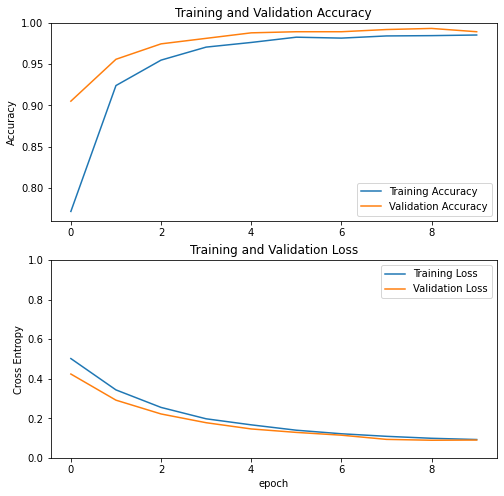

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [23]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

4/4 [==============================] - 26s 7s/step - loss: 0.1142 - accuracy: 0.9844
Test accuracy : 0.984375


In [29]:
model.save("models/inceptionResNetV2_optimized_h5/inceptionResNetV2_optimized.h5")

In [27]:
new_model = tf.keras.models.load_model('models/inceptionResNetV2_optimized')

new_model.summary()


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 299, 299, 3)       0         
_________________________________________________________________
tf_op_layer_RealDiv (TensorF (None, 299, 299, 3)       0         
_________________________________________________________________
tf_op_layer_Sub (TensorFlowO (None, 299, 299, 3)       0         
_________________________________________________________________
inception_resnet_v2 (Functio (None, 8, 8, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1536)             